In [1]:
import numpy as np
from scipy.stats import norm, poisson
import matplotlib.pyplot as plt
import pandas as pd
import chardet

class ConvertibleBondPricer:
    
    def __init__(self, S, K, T, r, sigma, conversion_ratio, credit_spread, trigger_price):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.conversion_ratio = conversion_ratio
        self.credit_spread = credit_spread
        self.trigger_price = trigger_price

    def black_scholes_price(self):
        """
        使用Black-Scholes模型定價
        """

        if self.S >= self.trigger_price:
            return self.S * self.conversion_ratio

        # 計算BS參數
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T) / \
             (self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        # 計算強制轉換機率
        h1 = (np.log(self.trigger_price/self.S) + 
              (self.r + 0.5*self.sigma**2)*self.T)/(self.sigma*np.sqrt(self.T))
        h2 = h1 - self.sigma*np.sqrt(self.T)
        prob_mandatory = norm.cdf(h1) + \
                        np.exp(2*self.r*np.log(self.trigger_price/self.S)/self.sigma**2)*norm.cdf(-h2)
        prob_mandatory = min(prob_mandatory, 1.0)

        # 計算組件價值
        bond_value = self.K * np.exp(-(self.r + self.credit_spread)*self.T) * (1 - prob_mandatory)
        option_value = self.conversion_ratio * (
            self.S * norm.cdf(d1) - 
            self.K * np.exp(-self.r*self.T) * norm.cdf(d2)
        ) * (1 - prob_mandatory)
        mandatory_value = self.S * self.conversion_ratio * prob_mandatory
        
        return bond_value + option_value + mandatory_value

    def binomial_tree_price(self, steps=100):
        """
        使用二叉樹模型定價
        """
        dt = self.T/steps
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(self.r*dt) - d)/(u - d)
        
        # 創建股價樹
        stock_tree = np.zeros((steps+1, steps+1))
        option_tree = np.zeros((steps+1, steps+1))
        
        # 初始化股價樹
        for j in range(steps+1):
            stock_tree[j,j] = self.S * (u**j) * (d**(steps-j))
            
            # 在末節點計算可轉債價值
            if stock_tree[j,j] >= self.trigger_price:
                option_tree[j,j] = stock_tree[j,j] * self.conversion_ratio
            else:
                option_tree[j,j] = max(
                    self.K,  # 債券價值
                    stock_tree[j,j] * self.conversion_ratio  # 轉換價值
                )
        
        # 向後遞迴
        for i in range(steps-1, -1, -1):
            for j in range(i+1):
                stock_price = self.S * (u**j) * (d**(i-j))
                
                if stock_price >= self.trigger_price:
                    option_tree[j,i] = stock_price * self.conversion_ratio
                else:
                    hold_value = np.exp(-(self.r + self.credit_spread)*dt) * \
                                (p * option_tree[j+1,i+1] + (1-p) * option_tree[j,i+1])
                    convert_value = stock_price * self.conversion_ratio
                    option_tree[j,i] = max(hold_value, convert_value)
        
        return option_tree[0,0]

    def monte_carlo_price(self, num_sims=10000, num_steps=100):
        """
        使用蒙特卡洛模擬定價
        """
        dt = self.T/num_steps
        prices = np.zeros(num_sims)
        
        for i in range(num_sims):
            price_path = np.zeros(num_steps+1)
            price_path[0] = self.S
            
            # 生成價格路徑
            for t in range(1, num_steps+1):
                z = np.random.standard_normal()
                price_path[t] = price_path[t-1] * np.exp(
                    (self.r - 0.5*self.sigma**2)*dt + self.sigma*np.sqrt(dt)*z
                )
                
                # 檢查是否觸發強制轉換
                if price_path[t] >= self.trigger_price:
                    prices[i] = price_path[t] * self.conversion_ratio
                    break
                    
                # 如果到達最後時間點
                if t == num_steps:
                    prices[i] = max(
                        self.K * np.exp(-(self.r + self.credit_spread)*self.T),
                        price_path[t] * self.conversion_ratio
                    )
        
        return np.mean(prices)

    def jump_diffusion_price(self, lambda_jump=1.0, mu_jump=-0.1, sigma_jump=0.2, num_sims=10000, num_steps=100):
        """
        Price convertible bond using Merton's jump diffusion model
        
        Parameters:
        - lambda_jump: Jump intensity (average number of jumps per year)
        - mu_jump: Average jump size
        - sigma_jump: Jump size volatility
        - num_sims: Number of Monte Carlo simulations
        - num_steps: Number of time steps
        
        Returns:
        - CB price under jump diffusion model
        """
        dt = self.T/num_steps
        sqrt_dt = np.sqrt(dt)
        
        # Initialize arrays
        S = np.zeros((num_sims, num_steps + 1))
        S[:, 0] = self.S
        
        # Calculate compensator for the jump component
        k = np.exp(mu_jump + 0.5 * sigma_jump**2) - 1
        # Adjust drift to ensure risk-neutral pricing
        adjusted_drift = self.r - lambda_jump * k - 0.5 * self.sigma**2
        
        # Generate diffusion component
        dW = np.random.standard_normal((num_sims, num_steps))
        
        # Generate jump component
        n_jumps = np.random.poisson(lambda_jump * dt, size=(num_sims, num_steps))
        jump_sizes = np.random.lognormal(
            mean=mu_jump - 0.5 * sigma_jump**2,
            sigma=sigma_jump,
            size=(num_sims, num_steps)
        )
        jumps = np.log(jump_sizes) * n_jumps
        
        # Simulate paths
        for t in range(num_steps):
            # Diffusion + Jump component
            S[:, t+1] = S[:, t] * np.exp(
                adjusted_drift * dt +           # Drift
                self.sigma * sqrt_dt * dW[:, t] +  # Diffusion
                jumps[:, t]                     # Jumps
            )
            
            # Check for mandatory conversion
            converted = S[:, t+1] >= self.trigger_price
            if np.any(converted):
                S[converted, t+1:] = S[converted, t+1:t+2]
        
        # Calculate payoffs
        payoff = np.zeros(num_sims)
        
        # For paths that hit trigger price (mandatory conversion)
        converted = np.any(S >= self.trigger_price, axis=1)
        payoff[converted] = S[converted, -1] * self.conversion_ratio
        
        # For paths that don't hit trigger price
        not_converted = ~converted
        conversion_value = S[not_converted, -1] * self.conversion_ratio
        bond_value = self.K * np.exp(-(self.r + self.credit_spread) * self.T)
        payoff[not_converted] = np.maximum(conversion_value, bond_value)
        
        # Calculate mean discounted payoff
        price = np.mean(payoff) * np.exp(-self.r * self.T)
        
        return price

    def compare_methods_with_jumps(self):
        """
        Compare different pricing methods including jump diffusion
        """
        methods = {
            'Black-Scholes': self.black_scholes_price(),
            'Binomial Tree': self.binomial_tree_price(),
            'Monte Carlo': self.monte_carlo_price(),
            'Jump Diffusion': self.jump_diffusion_price()
        }
        return methods

    def plot_comparison_with_jumps(self, S_range=None):
        """
        Plot price comparison including jump diffusion method
        """
        if S_range is None:
            S_range = np.linspace(self.S * 0.5, self.S * 1.5, 50)
            
        bs_prices = []
        bin_prices = []
        mc_prices = []
        jd_prices = []
        
        original_S = self.S
        for s in S_range:
            self.S = s
            bs_prices.append(self.black_scholes_price())
            bin_prices.append(self.binomial_tree_price())
            mc_prices.append(self.monte_carlo_price())
            jd_prices.append(self.jump_diffusion_price())
        self.S = original_S
        
        plt.figure(figsize=(12, 6))
        plt.plot(S_range, bs_prices, 'b-', label='Black-Scholes')
        plt.plot(S_range, bin_prices, 'g--', label='Binomial Tree')
        plt.plot(S_range, mc_prices, 'r:', label='Monte Carlo')
        plt.plot(S_range, jd_prices, 'm-.', label='Jump Diffusion')
        plt.axvline(x=self.trigger_price, color='k', linestyle=':', label='Trigger Price')
        plt.xlabel('Stock Price')
        plt.ylabel('CB Price')
        plt.title('Convertible Bond Price Comparison')
        plt.legend()
        plt.grid(True)
        plt.show()

Black-Scholes Price: 119.00
Binomial Tree Price: 119.00
Monte Carlo Price: 123.55
Jump Diffusion Price: 120.51


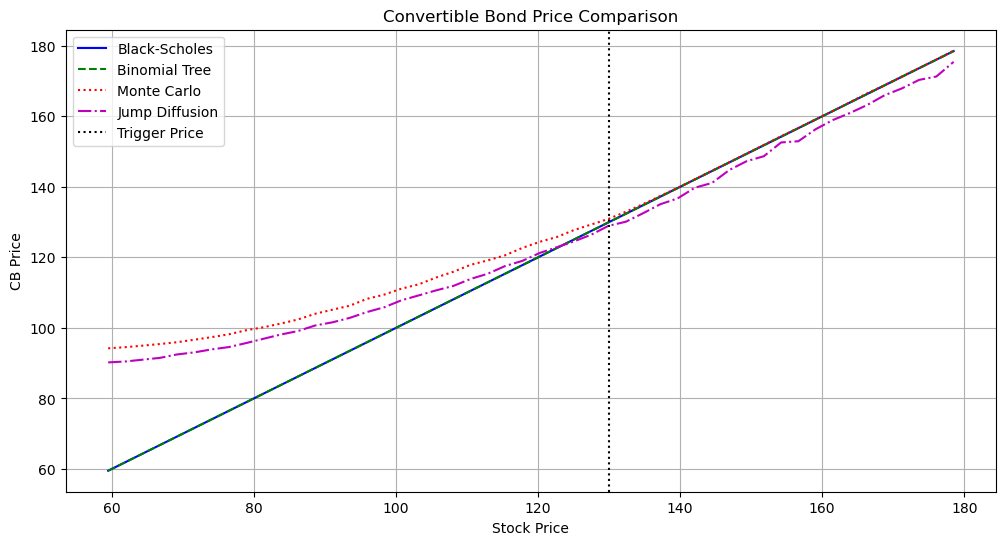

In [2]:
# 設定參數
S = 119  # 股票現價
K = 100  # 債券面額
T = 1    # 到期時間（年）
r = 0.05 # 無風險利率
sigma = 0.3  # 波動率
conversion_ratio = 1.0  # 轉換比率
credit_spread = 0.02  # 信用利差
trigger_price = 130  # 強制轉換觸發價格

pricer = ConvertibleBondPricer(S, K, T, r, sigma, conversion_ratio, 
                              credit_spread, trigger_price)

# 比較三種方法的結果
results = pricer.compare_methods_with_jumps()
for method, price in results.items():
    print(f"{method} Price: {price:.2f}")

# 繪製比較圖
pricer.plot_comparison_with_jumps()